# Build RNN Classification Model

**Using the Human Activity Recognition dataset, build a multi-class classification RNN model, to identify six types of activity from nine univariate time series.**

**Time series:**

    X, Y, Z time series for Body Acceleration (3)
    X, Y, Z time series for Total Acceleration (3)
    X, Y, Z time series for Body Gyro (3)
    
**Class labels:**

    WALKING
    WALKING_UPSTAIRS
    WALKING_DOWNSTAIRS
    STANDING 
    SITTING
    LAYING
    
**The data has been cleaned and pre-processed for use in any supervised machine-learning model, with the separate univariate time series ready to combine for use in neural networks, as well as all available data arranged in *static* training and test sets so that you can use as features for more traditional machine-learning models in SciKit-Learn.**

**NOTE: Since the dataset is quite large, it is advised to add checkpoints when training the models, so that you can save the best model.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

%matplotlib inline

In [2]:
# Access to training files

from os import listdir

dir_path = 'data/UCI-HAR/UCI HAR Dataset/train'

res = listdir(dir_path)
print(res)

['Inertial Signals', 'subject_train.txt', 'X_train.txt', 'y_train.txt']


In [3]:
# Obtain size variables by inspecting the files

T = 128

Ntrain = 7352

Ntest = 2947

D = 9 # Since there are 9 files

K = 6 # No of classes (1-6)

In [4]:
# Function to load HAR data and arrange into training and test sets

def load_data():
    # Returns:
    # Xtrain (Ntrain x T x D), Ytrain (Ntrain)
    # Xtest (Ntest x T x D), Ytest (Ntest)
    
    Xtrain = np.zeros((Ntrain, T, D))
    Xtest = np.zeros((Ntest, T, D))
    
    # Training input
    ts_filenames = ['body_acc_x_train.txt', 
                    'body_gyro_x_train.txt', 
                    'total_acc_x_train.txt', 
                    'body_acc_y_train.txt', 
                    'body_gyro_y_train.txt', 
                    'total_acc_y_train.txt', 
                    'body_acc_z_train.txt', 
                    'body_gyro_z_train.txt', 
                    'total_acc_z_train.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/train/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntrain x T
        x = df.to_numpy()
        Xtrain[:, :, d] = x
        
    # Training labels
    Ytrain = pd.read_csv(f'{ts_file_prefix}y_train.txt', header=None).to_numpy() - 1
    
    # Test input
    ts_filenames = ['body_acc_x_test.txt', 
                    'body_gyro_x_test.txt', 
                    'total_acc_x_test.txt', 
                    'body_acc_y_test.txt', 
                    'body_gyro_y_test.txt', 
                    'total_acc_y_test.txt', 
                    'body_acc_z_test.txt', 
                    'body_gyro_z_test.txt', 
                    'total_acc_z_test.txt']
    
    ts_file_prefix = 'data/UCI-HAR/UCI HAR Dataset/test/'
    
    for d, fn in enumerate(ts_filenames):
        df = pd.read_csv(f'{ts_file_prefix}Inertial Signals/{fn}', header=None, delim_whitespace=True)
        
        # Ntest x T
        x = df.to_numpy()
        Xtest[:, :, d] = x
        
    # Test labels
    Ytest = pd.read_csv(f'{ts_file_prefix}y_test.txt', header=None).to_numpy() - 1
    
    return Xtrain, Ytrain, Xtest, Ytest

In [5]:
X_train, y_train, X_test, y_test = load_data()

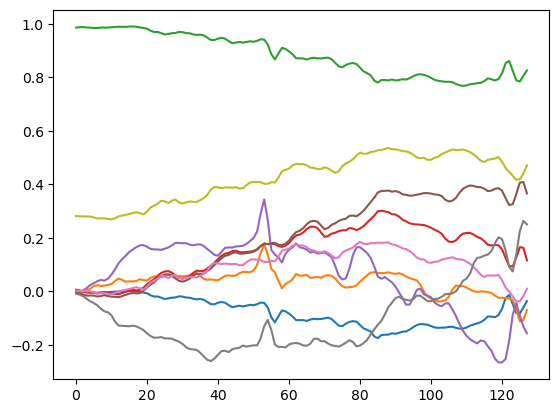

In [6]:
# Plot all 9 time series of length T for single sample

plt.plot(X_train[7000, :, :]);

## LSTM RNN

In [7]:
i = Input(shape=(T, D))

x = LSTM(32, return_sequences=True)(i)
x = LSTM(32, return_sequences=True)(x)

x = GlobalMaxPooling1D()(x)

x = Dense(K)(x)

model = Model(i, x)

In [8]:
# Create checkpoint - see in data folder

check_point = ModelCheckpoint('data/best_model.h5', monitor='val_loss', save_best_only=True)

In [9]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [10]:
r = model.fit(X_train, 
              y_train, 
              epochs=10, 
              callbacks=[check_point], 
              validation_data=(X_test, y_test))

Epoch 1/10
230/230 [==============================] - 21s 75ms/step - loss: 0.9367 - accuracy: 0.7145 - val_loss: 0.6426 - val_accuracy: 0.7927
Epoch 2/10
230/230 [==============================] - 18s 79ms/step - loss: 0.4037 - accuracy: 0.8769 - val_loss: 0.4272 - val_accuracy: 0.8585
Epoch 3/10
230/230 [==============================] - 19s 85ms/step - loss: 0.2253 - accuracy: 0.9362 - val_loss: 0.3027 - val_accuracy: 0.8928
Epoch 4/10
230/230 [==============================] - 19s 82ms/step - loss: 0.1829 - accuracy: 0.9353 - val_loss: 0.2877 - val_accuracy: 0.9009
Epoch 5/10
230/230 [==============================] - 18s 77ms/step - loss: 0.1417 - accuracy: 0.9514 - val_loss: 0.2629 - val_accuracy: 0.9111
Epoch 6/10
230/230 [==============================] - 17s 75ms/step - loss: 0.1467 - accuracy: 0.9453 - val_loss: 0.2717 - val_accuracy: 0.9070
Epoch 7/10
230/230 [==============================] - 18s 77ms/step - loss: 0.1288 - accuracy: 0.9550 - val_loss: 0.2775 - val_accuracy:

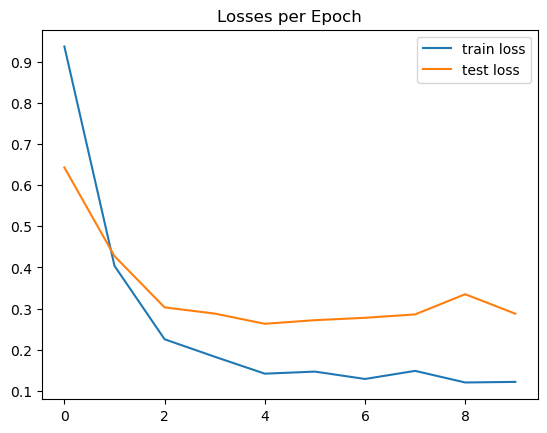

In [11]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

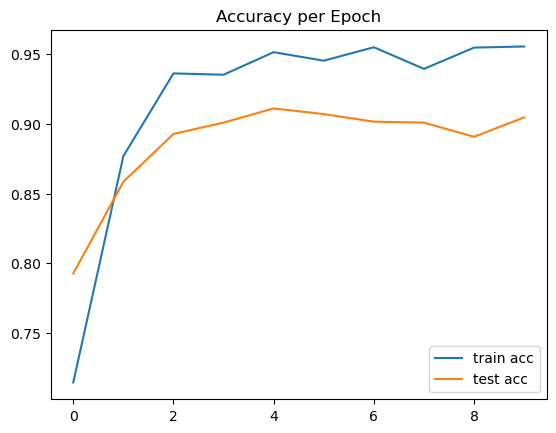

In [12]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracy per Epoch")
plt.legend();

**Both training and test losses converge, as do the accuracy scores, so the model is behaving as it should.**

In [13]:
# Load best model

best_model = tf.keras.models.load_model('data/best_model.h5')

In [14]:
# Make predictions with best model

P_test = best_model.predict(X_test)

93/93 [==============================] - 2s 20ms/step


In [15]:
# Evaluate best model

np.mean(np.argmax(P_test, axis=1) == y_test.flatten())

0.9110960298608755

**This is a pretty good score, but confirms that it performs worse than other models using this dataset. Combine feature-based data in an ANN with the time series RNN using 'concatenation layer', to see if the model can better learn the data.**

## Combine feature-based ANN with LSTM RNN

**The models themselves can be combined using `Concatenate` layer in TensorFlow, but remember that the input data needs to be combined also. Since input is essentially in list format, you can use `+` operator or combine them in a list parameters `[]` when training the model.**

**NOTE: When using static data in a feed-forward network, it is beneficial to always standardize the data.**

In [16]:
from sklearn.preprocessing import StandardScaler

def load_features():
    # Returns:
    # X_train (Ntrain x D)
    # X_test (Ntest x D)
    
    # Training input
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/train/X_train.txt', header=None, delim_whitespace=True)
    
    feat_train = df.to_numpy()
    
    # Test input
    df = pd.read_csv('data/UCI-HAR/UCI HAR Dataset/test/X_test.txt', header=None, delim_whitespace=True)
    
    feat_test = df.to_numpy()
    
    scaler = StandardScaler()
    feat_train = scaler.fit_transform(feat_train)
    feat_test = scaler.transform(feat_test)
    
    return feat_train, feat_test

In [17]:
feat_train, feat_test = load_features()

In [18]:
# N x T

feat_train.shape

(7352, 561)

In [19]:
feat_test.shape

(2947, 561)

In [20]:
# Obtain no of features (T) for ANN

D_feat = feat_train.shape[1]

In [21]:
# Time series RNN

i = Input(shape=(T, D))

x = LSTM(32, return_sequences=True)(i)

x = GlobalMaxPooling1D()(x)

# Feature-based ANN

i2 = Input(shape=(D_feat,))

x2 = Dense(32, activation='relu')(i2)

# Combine models

x = Concatenate()([x, x2])

# Outer layer

x = Dense(K)(x)

model = Model([i, i2], x)

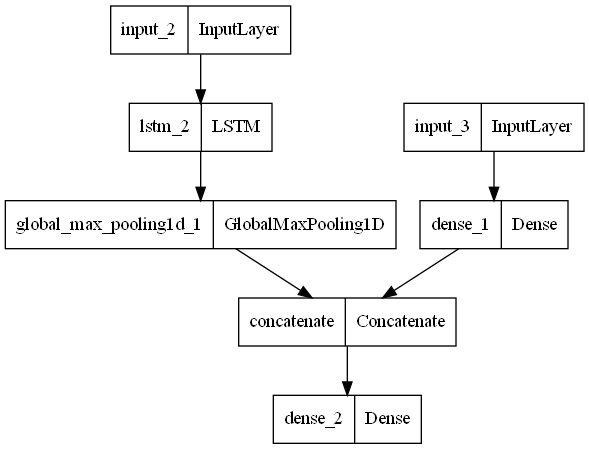

In [22]:
tf.keras.utils.plot_model(model)

In [23]:
# Create checkpoint - see in data folder

check_point = ModelCheckpoint('data/combined_best_model.h5', monitor='val_accuracy', save_best_only=True)

In [24]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [25]:
r = model.fit([X_train, feat_train], 
              y_train, 
              epochs=15, 
              callbacks=[check_point], 
              validation_data=([X_test, feat_test], y_test))

Epoch 1/15
230/230 [==============================] - 11s 40ms/step - loss: 0.3169 - accuracy: 0.8891 - val_loss: 0.1901 - val_accuracy: 0.9298
Epoch 2/15
230/230 [==============================] - 8s 34ms/step - loss: 0.1040 - accuracy: 0.9656 - val_loss: 0.1865 - val_accuracy: 0.9277
Epoch 3/15
230/230 [==============================] - 9s 40ms/step - loss: 0.0713 - accuracy: 0.9742 - val_loss: 0.1825 - val_accuracy: 0.9345
Epoch 4/15
230/230 [==============================] - 8s 37ms/step - loss: 0.0598 - accuracy: 0.9791 - val_loss: 0.1695 - val_accuracy: 0.9393
Epoch 5/15
230/230 [==============================] - 9s 39ms/step - loss: 0.0510 - accuracy: 0.9823 - val_loss: 0.1887 - val_accuracy: 0.9365
Epoch 6/15
230/230 [==============================] - 9s 38ms/step - loss: 0.0472 - accuracy: 0.9834 - val_loss: 0.2055 - val_accuracy: 0.9342
Epoch 7/15
230/230 [==============================] - 9s 38ms/step - loss: 0.0488 - accuracy: 0.9829 - val_loss: 0.2287 - val_accuracy: 0.929

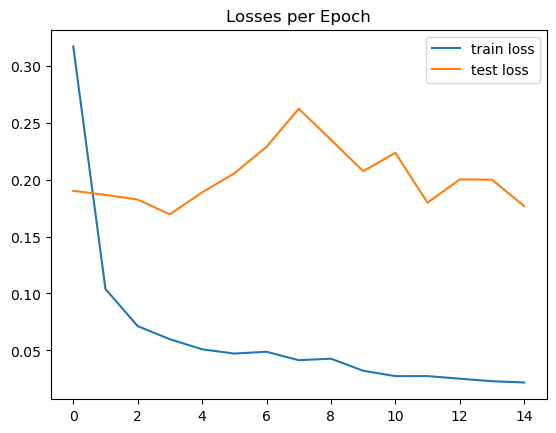

In [26]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Losses per Epoch")
plt.legend();

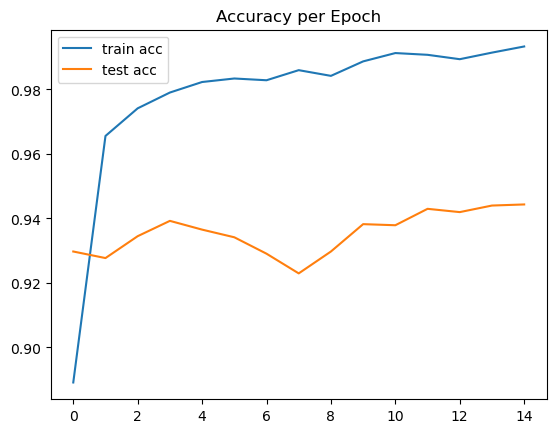

In [27]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.title("Accuracy per Epoch")
plt.legend();

**Test losses and accuracy are bit irratic but show steady behaviour during convergence, whilst training losses and accuracy look good. Also, you can see that accuracy is higher with this model.**

In [28]:
# Load best combined model

best_model = tf.keras.models.load_model('data/combined_best_model.h5')

In [29]:
# Make predictions with best combined model

Ptest = best_model.predict([X_test, feat_test])

93/93 [==============================] - 1s 12ms/step


In [30]:
# Evaluate best combined model

np.mean(np.argmax(Ptest, axis=1) == y_test.flatten())

0.9443501866304717

**Using accuracy as a performance metric, you can see that this model performs better than the RNN alone, so combining static features has improved model learning. However, it still does not outperform other neural networks you have seen with this data.**

**EXERCISE:**

* **Use GRU layers instead of LSTM to compare model performance.**